# With the new control and armflapping videos (shorter directories), let's see whether we can get a higher accuracy. 

In [2]:
import cv2, os 
import numpy as np 
import warnings 
warnings.filterwarnings("ignore")

## create a function to detect all landmarks in a given frame 

In [3]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp


def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 42 # use 0 as default if the class is not there 
    Y_locations = [0] * 42 
    Z_locations = [0] * 42
    x = y = z = 0 
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y
                Z_locations[z] = landmark.z
                x += 1; y += 1; z += 1; 
    locations = np.concatenate([X_locations, Y_locations, Z_locations])
    hands.close()
    return locations 

In [4]:
# time to actually do calibration. 

SECONDS_TO_DETECT = 2 # in seconds
DISTANCE_BETWEEN_INPUTS = 0.01 # in seconds, only matters if sampling is True
sampling = False 

import os, cv2
from tqdm import tqdm 
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []
ARMFLAPPING_FPS = [] # store the FPS of all armflapping videos 
CONTROL_FPS = [] # store the FPS of all control videos 
for video_name in tqdm(os.listdir('behavior_data/shorter_armflapping'), desc = "armflapping_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_armflapping/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image) 
        
        ARMFLAPPING_VIDEOS.append(FRAMES)
        ARMFLAPPING_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

for video_name in tqdm(os.listdir('behavior_data/shorter_control'), desc = "control_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_control/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image)
        
        CONTROL_VIDEOS.append(FRAMES)
        CONTROL_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")
    
len(ARMFLAPPING_VIDEOS), len(CONTROL_VIDEOS)

armflapping_videos:  15%|█▍        | 16/108 [00:00<00:02, 33.06it/s]

failed on .DS_Store


control_videos:  23%|██▎       | 14/62 [00:00<00:02, 16.61it/s]

failed on .DS_Store


control_videos: 100%|██████████| 62/62 [00:03<00:00, 19.38it/s]


(97, 50)

In [6]:
# get the locations of all of the videos 

ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []
for FRAMES in tqdm(ARMFLAPPING_VIDEOS) :
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    ARMFLAPPING_LOCATIONS.append(locs)

for FRAMES in tqdm(CONTROL_VIDEOS):  
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    CONTROL_LOCATIONS.append(locs)

100%|██████████| 50/50 [01:43<00:00,  2.07s/it]


In [7]:
print([len(video) for video in ARMFLAPPING_LOCATIONS])
print([len(video) for video in CONTROL_LOCATIONS])

[121, 61, 121, 90, 90, 90, 72, 90, 90, 49, 49, 90, 90, 90, 72, 90, 121, 49, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 121, 90, 90, 90, 90, 91, 90, 120, 90, 90, 121, 91, 90, 90, 90, 90, 45, 45, 121, 90, 90, 45, 90, 72, 60, 90, 90, 91, 91, 49, 91, 121, 90, 90, 72, 90, 72, 72, 49, 49, 90, 45, 72, 72, 120, 121, 90, 90, 72, 90, 90, 49, 72, 45, 72, 91, 90, 90, 97, 121, 49, 45, 72, 73, 60, 72, 90, 72]
[121, 121, 90, 90, 72, 72, 90, 91, 49, 49, 49, 61, 45, 72, 72, 72, 73, 90, 60, 121, 90, 49, 90, 90, 73, 90, 73, 49, 121, 90, 90, 90, 60, 90, 121, 90, 41, 121, 45, 60, 121, 90, 90, 121, 90, 61, 46, 45, 45, 121]


In [8]:
# to balance classes 
N = min([len(locs) for locs in [ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS]])
ARMFLAPPING_LOCATIONS = ARMFLAPPING_LOCATIONS[:N]
CONTROL_LOCATIONS = CONTROL_LOCATIONS[:N]
ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)

## after balancing the classes, pad the data and convert to numpy arrays 

In [9]:
# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = np.array(locations).tolist() 
    empty_row = np.zeros((1, 126))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

padded_armflapping_locations = ARMFLAPPING_LOCATIONS
padded_control_locations = CONTROL_LOCATIONS
padded_armflapping_locations = pad(padded_armflapping_locations, maxlen = 90)
padded_control_locations = pad(padded_control_locations, maxlen = 90)
print(padded_control_locations.shape, padded_armflapping_locations.shape)
assert padded_armflapping_locations.shape == padded_control_locations.shape 

50it [00:00, 17889.21it/s]
50it [00:00, 7866.58it/s]

(50, 90, 126) (50, 90, 126)


In [10]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    return data, labels 
X, y = generate_data(padded_armflapping_locations, padded_control_locations)

## function below to plot the model accuracy + loss through training. 

In [11]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    test_frames = []
    import cv2 

    cap = cv2.VideoCapture(path)

    while True: 
        _, frame = cap.read() 
        if not _: break 

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = hand_locations(frame)

        test_frames.append(frame)

    test_frames = np.array([test_frames])
    test_frames = pad(test_frames, maxlen = 90)
    
    return model.predict(test_frames)

## create the augmenter() class to do shift augmentations

In [12]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] # [100, 42]
        Y_locations = X[:, 42:84] # [100, 42]
        Z_locations = X[:, 84:] # [100, 42]
        
        maximum = tf.math.reduce_max(Y_locations)
        minimum = tf.math.reduce_min(Y_locations)
            
        can_move_up = 1 - maximum # the amount it can move up 
        can_move_down = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("up")
            # move up in this case 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:,42:84] + move_up)

        else: 
            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:,42:84]-move_down)

        maximum = tf.math.reduce_max(X_locations)
        minimum = tf.math.reduce_min(X_locations)
            
        can_move_right = 1 - maximum 
        can_move_left = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:,:42]+move_right)
        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:,:42]-move_left)

        
        maximum = tf.math.reduce_max(Z_locations)
        minimum = tf.math.reduce_min(Z_locations)
        
        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:,84:]+move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:,84:]-move_close)

        return X


class Augmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X):
        return tf.map_fn(_shift, X)
        
        

In [13]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('all_points_folds'): 
    with open(f"all_points_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

## functions to plot the ROC and AURROC bar graph for each fold in a run, and for each run

In [14]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across runs')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"run {i + 1}" for i in range(len(average_aurocs))] + ["average run"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across runs")
    plt.show()

## k-fold cross validation shown below

In [19]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [16]:
import random 
def shuffle(X, y, seed = None):
    if not seed:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 126)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y
X, y = shuffle(X, y, seed=65)

In [17]:
import tensorflow as tf 
def make_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(),
        tf.keras.layers.LSTM(64, return_sequences=False), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(loss = "binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

## run 10 times to gather results!

Epoch 1/75
3/3 [==============================] - 1s 269ms/step - loss: 0.7007 - accuracy: 0.5500 - precision_3: 0.6000 - recall_3: 0.4286 - val_loss: 0.6871 - val_accuracy: 0.6500 - val_precision_3: 0.6000 - val_recall_3: 0.3750
Epoch 2/75
3/3 [==============================] - 0s 165ms/step - loss: 0.6689 - accuracy: 0.6875 - precision_3: 0.7073 - recall_3: 0.6905 - val_loss: 0.6824 - val_accuracy: 0.4500 - val_precision_3: 0.4211 - val_recall_3: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6727 - accuracy: 0.6250 - precision_3: 0.5882 - recall_3: 0.9524 - val_loss: 0.6699 - val_accuracy: 0.4500 - val_precision_3: 0.4211 - val_recall_3: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6603 - accuracy: 0.5750 - precision_3: 0.5556 - recall_3: 0.9524 - val_loss: 0.6540 - val_accuracy: 0.5000 - val_precision_3: 0.4444 - val_recall_3: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6438 -

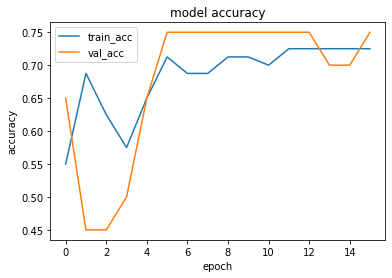

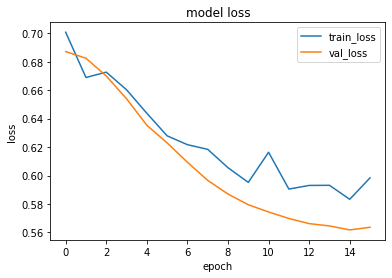

1it [00:00, 8208.03it/s]


prediction for video armflapping_1.mov is [[0.59800375]]


1it [00:00, 16320.25it/s]


prediction for video armflapping_3.mov is [[0.53101075]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.49795088]]


1it [00:00, 3938.31it/s]


prediction for video control_1.mov is [[0.2520947]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.68865836]]


1it [00:00, 18236.10it/s]


prediction for video control_3.mov is [[0.41407055]]
Epoch 1/75
3/3 [==============================] - 1s 215ms/step - loss: 0.6870 - accuracy: 0.5250 - precision_4: 0.4878 - recall_4: 0.5405 - val_loss: 0.6773 - val_accuracy: 0.7500 - val_precision_4: 0.8333 - val_recall_4: 0.7692
Epoch 2/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6837 - accuracy: 0.6375 - precision_4: 0.6053 - recall_4: 0.6216 - val_loss: 0.6666 - val_accuracy: 0.6500 - val_precision_4: 0.8000 - val_recall_4: 0.6154
Epoch 3/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6771 - accuracy: 0.6375 - precision_4: 0.6176 - recall_4: 0.5676 - val_loss: 0.6544 - val_accuracy: 0.7000 - val_precision_4: 0.8182 - val_recall_4: 0.6923
Epoch 4/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6564 - accuracy: 0.6875 - precision_4: 0.6500 - recall_4: 0.7027 - val_loss: 0.6408 - val_accuracy: 0.7500 - val_precision_4: 0.7857 - val_recall_4: 0.8462
Epoch 5/75
3/3 [===========

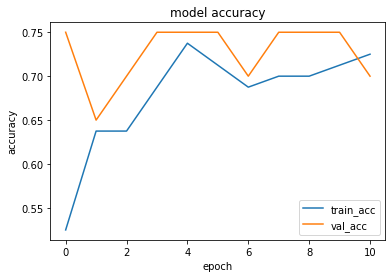

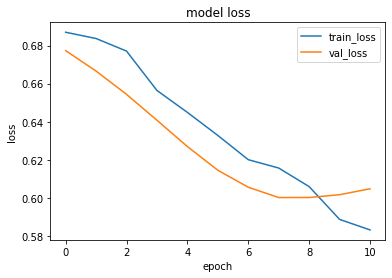

1it [00:00, 14217.98it/s]


prediction for video armflapping_1.mov is [[0.27190787]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_3.mov is [[0.55891126]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.21439168]]


1it [00:00, 16070.13it/s]


prediction for video control_1.mov is [[0.12007165]]


1it [00:00, 6288.31it/s]


prediction for video control_2.mov is [[0.8263812]]


1it [00:00, 7810.62it/s]


prediction for video control_3.mov is [[0.16616642]]
Epoch 1/75
3/3 [==============================] - 1s 241ms/step - loss: 0.6838 - accuracy: 0.5250 - precision_5: 0.5135 - recall_5: 0.4872 - val_loss: 0.6796 - val_accuracy: 0.6000 - val_precision_5: 0.6667 - val_recall_5: 0.5455
Epoch 2/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6876 - accuracy: 0.5875 - precision_5: 0.5833 - recall_5: 0.5385 - val_loss: 0.6693 - val_accuracy: 0.6000 - val_precision_5: 0.6154 - val_recall_5: 0.7273
Epoch 3/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6570 - accuracy: 0.7125 - precision_5: 0.6818 - recall_5: 0.7692 - val_loss: 0.6604 - val_accuracy: 0.6500 - val_precision_5: 0.6429 - val_recall_5: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6585 - accuracy: 0.7125 - precision_5: 0.6739 - recall_5: 0.7949 - val_loss: 0.6510 - val_accuracy: 0.6000 - val_precision_5: 0.6000 - val_recall_5: 0.8182
Epoch 5/75
3/3 [===========

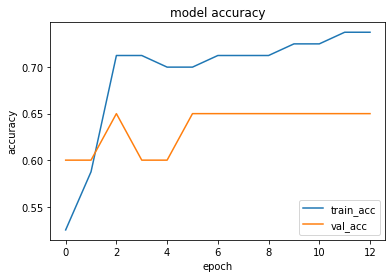

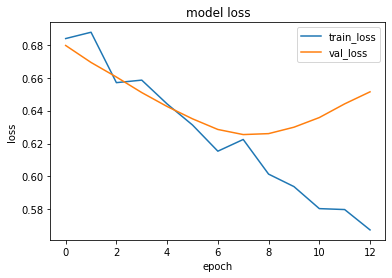

1it [00:00, 10754.63it/s]


prediction for video armflapping_1.mov is [[0.25452974]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.60360265]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.20727685]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.09872618]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.84703076]]


1it [00:00, 17924.38it/s]


prediction for video control_3.mov is [[0.17809391]]
Epoch 1/75
3/3 [==============================] - 1s 251ms/step - loss: 0.6819 - accuracy: 0.5250 - precision_6: 0.5294 - recall_6: 0.4500 - val_loss: 0.6630 - val_accuracy: 0.5500 - val_precision_6: 0.5333 - val_recall_6: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6783 - accuracy: 0.5500 - precision_6: 0.5303 - recall_6: 0.8750 - val_loss: 0.6402 - val_accuracy: 0.6000 - val_precision_6: 0.5556 - val_recall_6: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6593 - accuracy: 0.5750 - precision_6: 0.5417 - recall_6: 0.9750 - val_loss: 0.6231 - val_accuracy: 0.6000 - val_precision_6: 0.5556 - val_recall_6: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6563 - accuracy: 0.5500 - precision_6: 0.5286 - recall_6: 0.9250 - val_loss: 0.6077 - val_accuracy: 0.6000 - val_precision_6: 0.5556 - val_recall_6: 1.0000
Epoch 5/75
3/3 [===========

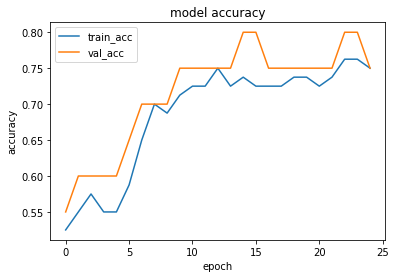

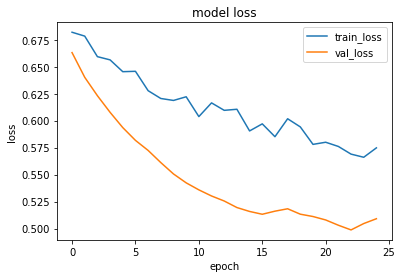

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.4925299]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_3.mov is [[0.5527563]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.25621063]]


1it [00:00, 17476.27it/s]


prediction for video control_1.mov is [[0.12546259]]


1it [00:00, 17189.77it/s]


prediction for video control_2.mov is [[0.8380952]]


1it [00:00, 18236.10it/s]


prediction for video control_3.mov is [[0.22418585]]
Epoch 1/75
3/3 [==============================] - 1s 255ms/step - loss: 0.6825 - accuracy: 0.5750 - precision_7: 0.5690 - recall_7: 0.7857 - val_loss: 0.6867 - val_accuracy: 0.3500 - val_precision_7: 0.3684 - val_recall_7: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6679 - accuracy: 0.6125 - precision_7: 0.5797 - recall_7: 0.9524 - val_loss: 0.6916 - val_accuracy: 0.3500 - val_precision_7: 0.3684 - val_recall_7: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6506 - accuracy: 0.6250 - precision_7: 0.5833 - recall_7: 1.0000 - val_loss: 0.6985 - val_accuracy: 0.3500 - val_precision_7: 0.3684 - val_recall_7: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6319 - accuracy: 0.5875 - precision_7: 0.5616 - recall_7: 0.9762 - val_loss: 0.7047 - val_accuracy: 0.4000 - val_precision_7: 0.3889 - val_recall_7: 0.8750
Epoch 5/75
3/3 [===========

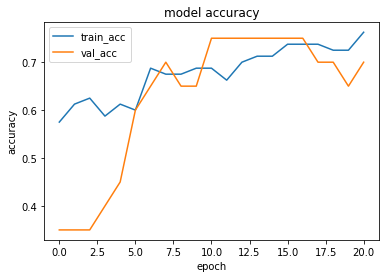

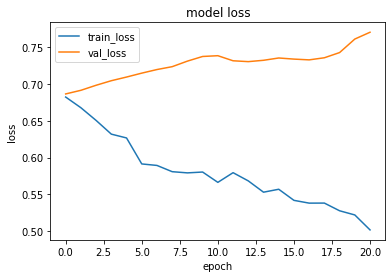

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.37626594]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_3.mov is [[0.63177085]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_2.mov is [[0.24952444]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.05828363]]


1it [00:00, 16980.99it/s]


prediction for video control_2.mov is [[0.92091966]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.16090241]]


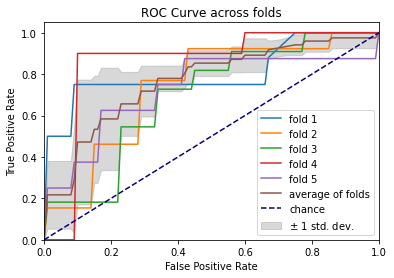

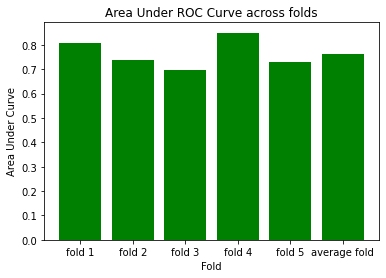

In [20]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 268ms/step - loss: 0.7236 - accuracy: 0.2750 - precision_9: 0.2778 - recall_9: 0.2381 - val_loss: 0.7070 - val_accuracy: 0.4000 - val_precision_9: 0.3889 - val_recall_9: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6954 - accuracy: 0.4125 - precision_9: 0.4590 - recall_9: 0.6667 - val_loss: 0.7032 - val_accuracy: 0.4000 - val_precision_9: 0.4000 - val_recall_9: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6719 - accuracy: 0.5750 - precision_9: 0.5541 - recall_9: 0.9762 - val_loss: 0.6919 - val_accuracy: 0.4500 - val_precision_9: 0.4211 - val_recall_9: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6616 - accuracy: 0.5750 - precision_9: 0.5526 - recall_9: 1.0000 - val_loss: 0.6832 - val_accuracy: 0.4500 - val_precision_9: 0.4211 - val_recall_9: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6537 -

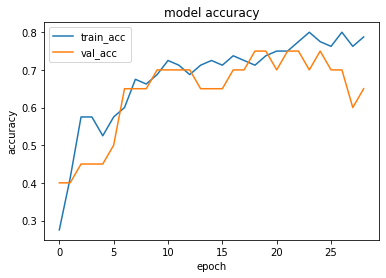

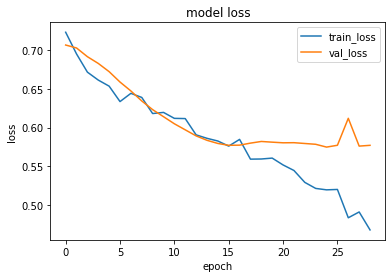

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.43376282]]


1it [00:00, 12633.45it/s]


prediction for video armflapping_3.mov is [[0.5865646]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_2.mov is [[0.35219085]]


1it [00:00, 17476.27it/s]


prediction for video control_1.mov is [[0.16856202]]


1it [00:00, 17260.51it/s]


prediction for video control_2.mov is [[0.78561544]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.25835788]]
Epoch 1/75
3/3 [==============================] - 1s 239ms/step - loss: 0.7184 - accuracy: 0.4625 - precision_10: 0.3636 - recall_10: 0.2162 - val_loss: 0.6907 - val_accuracy: 0.3500 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6967 - accuracy: 0.5625 - precision_10: 0.5500 - recall_10: 0.2973 - val_loss: 0.6744 - val_accuracy: 0.7500 - val_precision_10: 0.8333 - val_recall_10: 0.7692
Epoch 3/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6798 - accuracy: 0.6500 - precision_10: 0.6098 - recall_10: 0.6757 - val_loss: 0.6571 - val_accuracy: 0.7500 - val_precision_10: 0.7857 - val_recall_10: 0.8462
Epoch 4/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6603 - accuracy: 0.6750 - precision_10: 0.6341 - recall_10: 0.7027 - val_loss: 0.6444 - val_accuracy: 0.7500 - val_precision_10: 0.7857 - val_recall_10: 0.8462
Epo

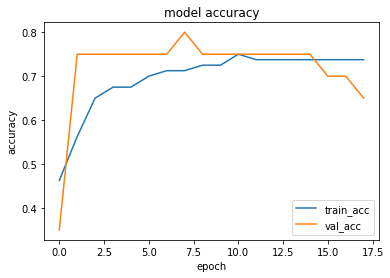

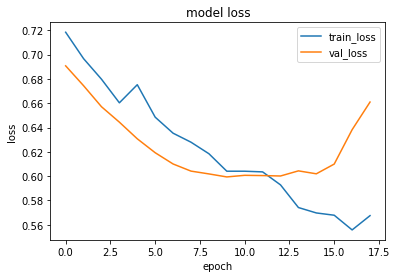

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.43726778]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.5266749]]


In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

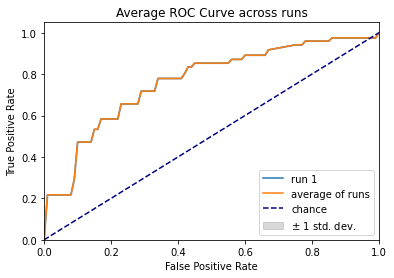

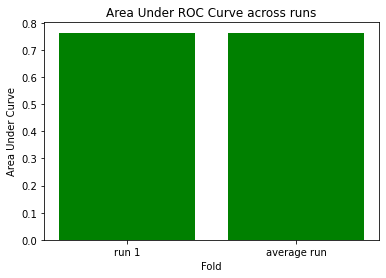

In [ ]:
plot_meta_roc_auroc(AVERAGE_AUROCS, AVERAGE_TPRS, base_fpr = np.linspace(0, 1, 101)) 